<a href="https://colab.research.google.com/github/Mirlaa/Challenge-Data-Science-1ed/blob/main/semana-2/Challenge_de_Dados_Semana_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1 style="padding:0px; background-color:#0f4c5c; margin:0; color:white; font-family:newtimeroman; font-size:300%; text-align:center;border-radius: 25px 25px; overflow:hidden; font-weight:500">Challenge de Data Science - Semana 2<br></h1>

<div align="center"> <img src="https://i.imgur.com/oxab3uu.png" width="800px" /> </div>

### Introdução




Na semana 2 buscamos construir um modelo de ML que pudesse predizer de acordo com os dados bancários de cada cliente, se essa pessoa pode ou não se tornar inadimplente. Dessa vez, utilizamos o Python no ambiente do Google Colab para desenvolver nosso modelo.

In [104]:
# bibliotecas usadas:
import pandas as pd
import numpy as np
import pickle

# importes parciais realizados(em ordem de uso):
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import pickle


## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Dados para Análise</h1>

In [105]:
dados = pd.read_csv('../Dados/dados_juntos.csv')
dados.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,60000,Rent,2.0,Education,B,8000,11.26,0,0.13,N,3
1,40,70000,Mortgage,6.0,Education,A,18000,7.90,0,0.26,N,14
2,29,115000,Mortgage,3.0,Medical,C,22000,15.23,0,0.19,Y,7
3,26,84996,Rent,0.0,Medical,B,9000,11.26,0,0.11,N,2
4,23,54500,Rent,2.0,Debtconsolidation,A,8000,0.00,0,0.15,N,2


### Traduzindo o nome das colunas

Os nomes das colunas do DataFrame estão todos em inglês, o que prejudica a interpretação das variáveis. Vamos criar um dicionário para traduzir o nome das colunas para o português.

In [106]:
dicionario = {
    'person_age': 'idade',
    'person_income': 'salario',
    'person_home_ownership': 'situacao_moradia',
    'person_emp_length': 'tempo_trabalho',
    'loan_intent': 'motivo_emprestimo',
    'loan_grade': 'pontuacao_emprestimo',
    'loan_amnt': 'valor_emprestimo',
    'loan_int_rate': 'taxa_juros',
    'loan_status': 'inadimplencia',
    'loan_percent_income': 'renda_percentual_emprestimo',
    'cb_person_default_on_file': 'devendo',
    'cb_person_cred_hist_length': 'tempo_de_credito'
}

In [107]:
dados.rename(dicionario, axis = 1, inplace = True)

## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Análise Preliminardas dos Dados</h1>

Vamos iniciar o processo de análise dos dados para identificação de valores inconsistentes, presença de outliers e dados nulos que podem prejudicar o modelo de aprendizado de máquina.

-----

Vamos utilizar o método `info()` para identificar a presença de dados nulos e dtypes das colunas.

In [108]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34501 entries, 0 to 34500
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        34501 non-null  int64  
 1   salario                      34501 non-null  int64  
 2   situacao_moradia             34170 non-null  object 
 3   tempo_trabalho               34501 non-null  float64
 4   motivo_emprestimo            34186 non-null  object 
 5   pontuacao_emprestimo         34188 non-null  object 
 6   valor_emprestimo             34501 non-null  int64  
 7   taxa_juros                   34501 non-null  float64
 8   inadimplencia                34501 non-null  int64  
 9   renda_percentual_emprestimo  34501 non-null  float64
 10  devendo                      34131 non-null  object 
 11  tempo_de_credito             34501 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


* É possível identificar a presença de dados nulos nas colunas, que deverão ser tratadas posteriormente. 
* As variáveis `situacao_moradia`, `motivo_emprestimo`, `pontuacao_emprestimo` e `devendo` apresentam o dtype object e deverão passar por algum tratamento para serem utilizados na etapa de modelagem.
* O conjunto de dados possui 34501 registros e um total de 12 colunas.

---

O método `describe()` por padrão traz informações a respeito de cada uma das variáveis numéricas, o que auxilia na identificação de outliers, e fornece uma ideia geral da distribuição dos dados.

In [109]:
dados.describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
idade,34501.0,27.4706,6.8585,0.0,23.00,26.00,30.00,144.00
salario,34501.0,65379.9031,61448.7573,0.0,38000.00,55000.00,78750.00,6000000.00
tempo_trabalho,34501.0,4.6132,4.1592,0.0,2.00,4.00,7.00,123.00
valor_emprestimo,34501.0,9498.5653,6359.1317,0.0,5000.00,8000.00,12000.00,35000.00
taxa_juros,34501.0,9.8548,4.5629,0.0,7.49,10.59,13.11,23.22
inadimplencia,34501.0,0.2160,0.4115,0.0,0.00,0.00,0.00,1.00
renda_percentual_emprestimo,34501.0,0.1687,0.1075,0.0,0.09,0.15,0.23,0.83
tempo_de_credito,34501.0,5.8075,4.0635,0.0,3.00,4.00,8.00,30.00


Foi possível a identificação de valores discrepantes para as variáveis `idade` e `tempo_trabalho`.

Uma idade máxima de 144 anos e um tempo de trabalho de 123 são dados que não fazem sentido e serão removidos posteriormente do conjunto de dados.

---

Vamos checar os dados únicos de cada uma das variáveis categóricas para identificar se há a presença de valores nulos e a quantidade de categorias de cada uma das colunas, indicando qual tratamento precisa ser feito antes de seguir para a modelagem.

In [110]:
dados['situacao_moradia'].unique()

array(['Rent', 'Mortgage', 'Own', 'Other', nan], dtype=object)

In [111]:
dados['motivo_emprestimo'].unique()

array(['Education', 'Medical', 'Debtconsolidation', 'Personal', 'Venture',
       'Homeimprovement', nan], dtype=object)

In [112]:
dados['pontuacao_emprestimo'].unique()

array(['B', 'A', 'C', 'D', 'E', 'F', nan, 'G'], dtype=object)

In [113]:
dados['devendo'].unique()

array(['N', 'Y', nan], dtype=object)

In [114]:
colunas_nulas = dados[['situacao_moradia', 'motivo_emprestimo', 'pontuacao_emprestimo', 'devendo' ]].isnull().sum()
print(f'Colunas com dados nulos ou não preenchidos: \n{colunas_nulas}')

Colunas com dados nulos ou não preenchidos: 
situacao_moradia        331
motivo_emprestimo       315
pontuacao_emprestimo    313
devendo                 370
dtype: int64




* Todas as colunas categóricas possuem dados nulos que serão removidos
* As colunas `situacao_moradia`, `motivo_emprestimo` e `pontuacao_emprestimo` possuem mais de 2 categorias, portanto o procedimento de *one hot encoding* precisa ser realizado
* A coluna `devendo` possui duas categorias, portanto uma substituição desses valores para 0 e 1 será feita.



In [115]:
dados['inadimplencia'].value_counts(normalize = True)

0    0.783977
1    0.216023
Name: inadimplencia, dtype: float64

É possível identificar que a variável alvo é desbalanceada, o que pode acarretar em problemas na etapa de modelagem.

Podemos utilizar técnicas para realizar o balançeamento de dados posteriomente.

## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Limpeza dos dados</h1>

Vamos iniciar o processo de limpeza dos dados a partir da análise que foi realizada na etapa anterior.

Vamos checar a quantidade de registros antes e após a limpeza de dados nulos para descobrir quantos dados serão perdidos no processo. 

In [116]:
print(f'Quantidade de registros: {dados.shape[0]}')

Quantidade de registros: 34501


In [117]:
dados.isna().sum()

idade                            0
salario                          0
situacao_moradia               331
tempo_trabalho                   0
motivo_emprestimo              315
pontuacao_emprestimo           313
valor_emprestimo                 0
taxa_juros                       0
inadimplencia                    0
renda_percentual_emprestimo      0
devendo                        370
tempo_de_credito                 0
dtype: int64

A quantidade de dados nulos em relação à quantidade de registros total do conjunto de dados é muito pequena, portanto serão removidos sem perda de muita informação.

In [118]:
dados.dropna(inplace = True)

In [119]:
dados

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,21,60000,Rent,2.0,Education,B,8000,11.26,0,0.13,N,3
1,40,70000,Mortgage,6.0,Education,A,18000,7.90,0,0.26,N,14
2,29,115000,Mortgage,3.0,Medical,C,22000,15.23,0,0.19,Y,7
3,26,84996,Rent,0.0,Medical,B,9000,11.26,0,0.11,N,2
4,23,54500,Rent,2.0,Debtconsolidation,A,8000,0.00,0,0.15,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
34496,39,33996,Rent,6.0,Medical,D,4000,0.00,1,0.12,N,13
34497,24,36000,Mortgage,0.0,Homeimprovement,A,14775,6.62,0,0.41,N,4
34498,27,39600,Mortgage,11.0,Debtconsolidation,A,4800,6.76,0,0.12,N,9
34499,30,39996,Mortgage,8.0,Medical,C,10000,12.73,0,0.25,N,6


In [120]:
print(f'Quantidade de registros: {dados.shape[0]}')

Quantidade de registros: 33364


A quantidade de registros inicial era de 34501 e a final de 33364.

Foram removidos 1137 registros do conjunto de dados inicial.

### Discrepância <hr>

Vamos agora identificar quais dados são discrepantes e remover do conjunto de dados.

Filtraremos valores com idade maior que 100 anos e tempo de trabalho maior que 90 anos, apenas para critério de ponto de corte.

In [121]:
dados[(dados['idade'] > 100)]

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
13850,144,6000000,Mortgage,12.0,Personal,C,5000,12.73,0,0.00,N,25
17272,123,80004,Rent,2.0,Education,B,20400,10.25,0,0.25,N,3
22137,144,200000,Mortgage,4.0,Education,B,6000,11.86,0,0.03,N,2
23737,123,78000,Rent,7.0,Venture,B,20000,0.00,0,0.26,N,4
29224,144,250000,Rent,4.0,Venture,C,4800,13.57,0,0.02,N,3


In [122]:
dados[(dados['tempo_trabalho'] > 90)]

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
8200,22,59000,Rent,123.0,Personal,D,35000,16.02,1,0.59,Y,3
21177,21,192000,Mortgage,123.0,Venture,A,20000,6.54,0,0.10,N,4


In [123]:
dados = dados[(dados['idade'] < 110) & (dados['tempo_trabalho'] < 100)]
dados

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,21,60000,Rent,2.0,Education,B,8000,11.26,0,0.13,N,3
1,40,70000,Mortgage,6.0,Education,A,18000,7.90,0,0.26,N,14
2,29,115000,Mortgage,3.0,Medical,C,22000,15.23,0,0.19,Y,7
3,26,84996,Rent,0.0,Medical,B,9000,11.26,0,0.11,N,2
4,23,54500,Rent,2.0,Debtconsolidation,A,8000,0.00,0,0.15,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
34496,39,33996,Rent,6.0,Medical,D,4000,0.00,1,0.12,N,13
34497,24,36000,Mortgage,0.0,Homeimprovement,A,14775,6.62,0,0.41,N,4
34498,27,39600,Mortgage,11.0,Debtconsolidation,A,4800,6.76,0,0.12,N,9
34499,30,39996,Mortgage,8.0,Medical,C,10000,12.73,0,0.25,N,6


Por fim, alteraremos o tipo de dado da variável `tempo_trabalho` para tipo inteiro.

In [124]:
dados['tempo_trabalho'] = dados['tempo_trabalho'].astype('int64')

C:\Users\ricar\AppData\Local\Temp\ipykernel_1200\1175232491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['tempo_trabalho'] = dados['tempo_trabalho'].astype('int64')


Assim:
* a base de dados passou de 34501 registros para 33357, sendo removidos 1144 retirados do conjunto.

## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Tratamento de dados</h1>

Agora se inicia o processo de tratamento de dados para que possam ser usados na etapa de modelagem.

As variáveis categóricas serão transformadas em variáveis *dummy* e as variáveis serão normalizadas para ficarem em uma mesma escala para que variáveis com escalas maiores não tenham peso maior que as outras.

In [125]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33357 entries, 0 to 34500
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        33357 non-null  int64  
 1   salario                      33357 non-null  int64  
 2   situacao_moradia             33357 non-null  object 
 3   tempo_trabalho               33357 non-null  int64  
 4   motivo_emprestimo            33357 non-null  object 
 5   pontuacao_emprestimo         33357 non-null  object 
 6   valor_emprestimo             33357 non-null  int64  
 7   taxa_juros                   33357 non-null  float64
 8   inadimplencia                33357 non-null  int64  
 9   renda_percentual_emprestimo  33357 non-null  float64
 10  devendo                      33357 non-null  object 
 11  tempo_de_credito             33357 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 3.3+ MB


Vamos extrair a correlação entre as variáveis numéricas para entender se há alguma relação direta ou indireta entre as variáveis.

In [126]:
dados.corr()

,idade,salario,tempo_trabalho,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,tempo_de_credito
idade,1.000000,0.137635,0.161702,0.049830,0.010599,-0.017246,-0.032974,0.804475
salario,0.137635,1.000000,0.161947,0.310228,-0.001445,-0.163050,-0.286127,0.120578
tempo_trabalho,0.161702,0.161947,1.000000,0.118238,-0.028787,-0.088057,-0.059989,0.142806
valor_emprestimo,0.049830,0.310228,0.118238,1.000000,0.097055,0.104461,0.563776,0.042435
taxa_juros,0.010599,-0.001445,-0.028787,0.097055,1.000000,0.222766,0.081163,0.002211
inadimplencia,-0.017246,-0.163050,-0.088057,0.104461,0.222766,1.000000,0.374367,-0.015183
renda_percentual_emprestimo,-0.032974,-0.286127,-0.059989,0.563776,0.081163,0.374367,1.000000,-0.030991
tempo_de_credito,0.804475,0.120578,0.142806,0.042435,0.002211,-0.015183,-0.030991,1.000000


Notamos que a variável `renda_percentual_emprestimo` tem uma correlação alta de aproximadamente `57.71%` com `valor_emprestimo` e de fato essa variável é construída utilizando o salário e o valor do empréstimo solicitado pelo cliente.

Por isso iremos remover a coluna `renda_percentual_emprestimo`, para não haver informação duplicada no conjunto de dados.

In [127]:
dados2 = dados.drop('renda_percentual_emprestimo', axis = 1)

Para o processo de transformação das variáveis categóricas para dummys, é preciso substituir os valores da coluna `devendo` para 0 e 1, uma vez que essa variável possui apenas 2 classes.

In [128]:
dicionario = {
    'N': 0,
    'Y': 1
}

In [129]:
dados2.replace(dicionario, inplace = True)

## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">One Hot Encoding</h1>

Vamos fazer a divisão das variáveis explicativas da variável alvo do conjunto de dados. A variável alvo é a `inadimplencia`.

In [130]:
x = dados2.drop(['inadimplencia'], axis = 1)
y = dados2['inadimplencia']

In [131]:
display(x.head())
display(y.head())

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,devendo,tempo_de_credito
0,21,60000,Rent,2,Education,B,8000,11.26,0,3
1,40,70000,Mortgage,6,Education,A,18000,7.90,0,14
2,29,115000,Mortgage,3,Medical,C,22000,15.23,1,7
3,26,84996,Rent,0,Medical,B,9000,11.26,0,2
4,23,54500,Rent,2,Debtconsolidation,A,8000,0.00,0,2


0    0
1    0
2    0
3    0
4    0
Name: inadimplencia, dtype: int64

### Processo Encoding<hr>

As variáveis categóricas com mais de 2 categorias precisam passar por um processo de construção de novas colunas. Cada uma das novas colunas corresponde a uma das categorias e o valor será 1 caso o registro tenha a presença da característica e 0 caso contrário

Faremos a criação dessas novas colunas com o `OneHotEncoder`.

In [132]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [133]:
colunas_categoricas = ['situacao_moradia','motivo_emprestimo','pontuacao_emprestimo']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(), colunas_categoricas),
    remainder='passthrough')

dados_transformados = one_hot_enc.fit_transform(x)
dados_transformados = pd.DataFrame(dados_transformados, columns=one_hot_enc.get_feature_names_out())
dados_transformados.head()

,onehotencoder__situacao_moradia_Mortgage,onehotencoder__situacao_moradia_Other,onehotencoder__situacao_moradia_Own,onehotencoder__situacao_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,21.0,60000.0,2.0,8000.0,11.26,0.0,3.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,40.0,70000.0,6.0,18000.0,7.90,0.0,14.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,29.0,115000.0,3.0,22000.0,15.23,1.0,7.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,26.0,84996.0,0.0,9000.0,11.26,0.0,2.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,23.0,54500.0,2.0,8000.0,0.00,0.0,2.0


#### Normalização dos dados

A escala das variáveis numéricas do conjunto de dados é muito diferente e pode gerar um viés no modelo de machine learning. Desse modo, vamos normalizar os dados, colocando todos em uma mesma escala.

In [134]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(dados_transformados)

dados_transformados = scaler.transform(dados_transformados)
dados_transformados = pd.DataFrame(dados_transformados, columns = one_hot_enc.get_feature_names_out())
dados_transformados

,onehotencoder__situacao_moradia_Mortgage,onehotencoder__situacao_moradia_Other,onehotencoder__situacao_moradia_Own,onehotencoder__situacao_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.223404,0.029415,0.048780,0.228571,0.484927,0.0,0.035714
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.425532,0.034317,0.146341,0.514286,0.340224,0.0,0.428571
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.308511,0.056379,0.073171,0.628571,0.655900,1.0,0.178571
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.276596,0.041669,0.000000,0.257143,0.484927,0.0,0.000000
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.244681,0.026719,0.048780,0.228571,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33352,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.414894,0.016666,0.146341,0.114286,0.000000,0.0,0.392857
33353,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.255319,0.017649,0.000000,0.422143,0.285099,0.0,0.071429
33354,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.287234,0.019414,0.268293,0.137143,0.291128,0.0,0.250000
33355,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.319149,0.019608,0.195122,0.285714,0.548234,0.0,0.142857


#### Separação de dados (treino e teste)

Para realizar a validação de dados e conseguir avaliar se o modelo está se saindo bem, vamos dividir os dados em conjuntos de treinamento e teste.

In [135]:
from sklearn.model_selection import train_test_split

SEED = 144

x_treino, x_teste, y_treino, y_teste = train_test_split(dados_transformados, y, random_state = SEED, stratify = y)
y_teste


20783    0
26592    0
19476    0
11340    0
28214    0
        ..
30590    0
24846    0
17913    0
24049    0
28851    0
Name: inadimplencia, Length: 8340, dtype: int64

In [136]:
print(f'Assim o conjunto de dados Treino possui {x_treino.shape[0]} linhas.')
print(f'E o conjunto de teste possui {x_teste.shape[0]} linhas.')

Assim o conjunto de dados Treino possui 25017 linhas.
E o conjunto de teste possui 8340 linhas.


## <h1 style="padding:10px;background-color:orange;margin:0;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Aprendendo</h1>

A Alura Cash deseja identificar os clientes inadimplentes, e essa etapa de modelagem é o foco desse trabalho. Acontece que a variável `inadimplencia` se encontra desbalanceada.

Serão usadas duas técnicas de balanceamento de dados, uma de Oversampling e outra de Undersampling e os resultados das duas estratégias serão comparadas com a utilização de 3 algoritmos diferentes.

Os algoritmos que serão usados são a Árvore de Decisão, Gradient Boosting e Regressão Logística. Esses modelos foram escolhidos pela explicabilidade que é importante para o problema de negócio que desejamos resolver, que é a análise de risco de inadimplência.

A métrica principal a ser analisada é o recall, que indica a proporção de clientes que são inadimplentes mas o modelo não detectou, que podem gerar grande prejuízo para a empresa.




Import de modelos:

In [137]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

Import de métricas:

In [138]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors

### Aprendizado Oversampling

Vamos utilizar a técnica de oversampling SMOTE para balancear a variável alvo, construindo dados sintéticos da categoria com menos frequência.

In [139]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = SEED)
X_balanceado_over, y_balanceado_over = smote.fit_resample(x_treino, y_treino)
X_balanceado_over

,onehotencoder__situacao_moradia_Mortgage,onehotencoder__situacao_moradia_Other,onehotencoder__situacao_moradia_Own,onehotencoder__situacao_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.414894,0.049172,0.048780,0.714286,0.676141,1.0,0.500000
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.234043,0.014707,0.000000,0.257143,0.580965,1.0,0.071429
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.276596,0.083342,0.000000,0.342857,0.584410,1.0,0.000000
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.319149,0.025491,0.121951,0.091429,0.301034,0.0,0.285714
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.265957,0.029415,0.219512,0.385714,0.322567,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39199,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.225089,0.008597,0.003862,0.091359,0.000000,0.0,0.071429
39200,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.264765,0.029964,0.073171,0.688916,0.477497,0.0,0.063425
39201,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.255319,0.036030,0.017943,0.392970,0.000000,0.0,0.006569
39202,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.257201,0.021493,0.159283,0.512128,0.466581,0.0,0.071429


#### DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      6535
           1       0.63      0.76      0.69      1805

    accuracy                           0.85      8340
   macro avg       0.78      0.82      0.79      8340
weighted avg       0.86      0.85      0.86      8340



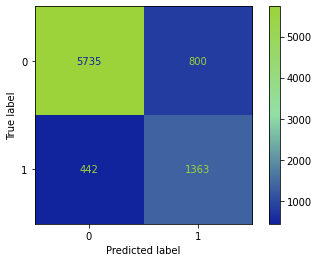

In [140]:
arvore = DecisionTreeClassifier(random_state=SEED)
arvore.fit(X_balanceado_over, y_balanceado_over)

previsao_arvore = arvore.predict(x_teste)

print(classification_report(y_teste, previsao_arvore))

mapa_calor = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#12239e","#92dfa6","#9cd33b"])

ConfusionMatrixDisplay.from_estimator(arvore, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('over-DecisionTree.png', format='png')
plt.show()

#### GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      6535
           1       0.65      0.75      0.70      1805

    accuracy                           0.86      8340
   macro avg       0.79      0.82      0.80      8340
weighted avg       0.87      0.86      0.86      8340



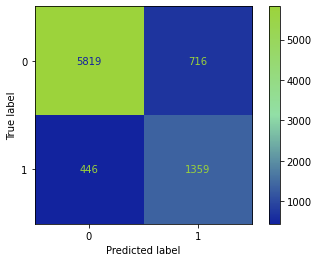

In [141]:
gboost = GradientBoostingClassifier(random_state=SEED)
gboost.fit(X_balanceado_over, y_balanceado_over)
previsao_gboost = gboost.predict(x_teste)

print(classification_report(y_teste, previsao_gboost))

ConfusionMatrixDisplay.from_estimator(gboost, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('over-GradientBoosting.png', format='png')
plt.show()

#### LogisticRegression

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      6535
           1       0.46      0.73      0.56      1805

    accuracy                           0.75      8340
   macro avg       0.68      0.74      0.69      8340
weighted avg       0.81      0.75      0.77      8340



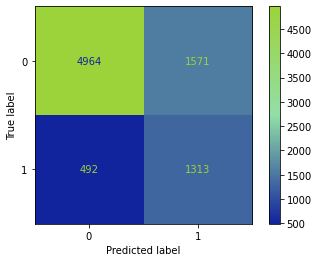

In [142]:
reg_logistica = LogisticRegression(random_state=SEED, max_iter =1000)
reg_logistica.fit(X_balanceado_over, y_balanceado_over)
previsao_reglog = reg_logistica.predict(x_teste)

print(classification_report(y_teste, previsao_reglog))

ConfusionMatrixDisplay.from_estimator(reg_logistica, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('over-LogisticRegression.png', format='png')
plt.show()

Os resultados dos modelos utilizando a técnica de oversampling foram salvos para posterior comparação com a técnica de undersampling.

In [143]:
from sklearn.metrics import recall_score
metricas_over = pd.DataFrame({'Acurácia treino':[arvore.score(x_treino, y_treino), 
                                 gboost.score(x_treino, y_treino), 
                                 reg_logistica.score(x_treino, y_treino)], 
            'Acurácia teste': [arvore.score(x_teste, y_teste), 
                                 gboost.score(x_teste, y_teste), 
                                 reg_logistica.score(x_teste, y_teste)], 
            'Recall':[recall_score(y_teste, previsao_arvore),
                      recall_score(y_teste, previsao_gboost),
                      recall_score(y_teste, previsao_reglog)]},
             index = ['Árvore de Decisão Oversampling', 'Gradient Boosting Oversampling', 'Regressão Logísitica Oversampling'])

In [144]:
metricas_over

,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Oversampling,1.000000,0.851079,0.755125
Gradient Boosting Oversampling,0.871208,0.860671,0.752909
Regressão Logísitica Oversampling,0.771835,0.752638,0.727424


### Aprendizado Undersampling

Agora será realizado o balanceamento da variável alvo utilizando a técnica de undersampling, que removerá aleatoriamente registros da classe mais frequente, igualando a quantidade de registros das duas classes.

In [145]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(random_state=SEED,sampling_strategy=0.5)
X_balanceado_under, y_balanceado_under = under.fit_resample(x_treino, y_treino)
X_balanceado_under

,onehotencoder__situacao_moradia_Mortgage,onehotencoder__situacao_moradia_Other,onehotencoder__situacao_moradia_Own,onehotencoder__situacao_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.468085,0.023532,0.000000,0.142857,0.578381,0.0,0.535714
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.276596,0.010589,0.000000,0.120000,0.430233,0.0,0.035714
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.340426,0.029415,0.048780,0.203571,0.430233,0.0,0.178571
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.223404,0.039220,0.121951,0.142857,0.559432,0.0,0.000000
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.265957,0.075502,0.024390,0.274286,0.471576,0.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16240,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.372340,0.046587,0.048780,0.142857,0.621016,1.0,0.142857
16241,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.436170,0.011766,0.585366,0.057143,0.333764,0.0,0.535714
16242,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.297872,0.016668,0.292683,0.105714,0.297588,0.0,0.214286
16243,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.308511,0.013237,0.243902,0.113571,0.524117,0.0,0.107143


#### DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      6535
           1       0.60      0.76      0.67      1805

    accuracy                           0.84      8340
   macro avg       0.77      0.81      0.78      8340
weighted avg       0.86      0.84      0.85      8340



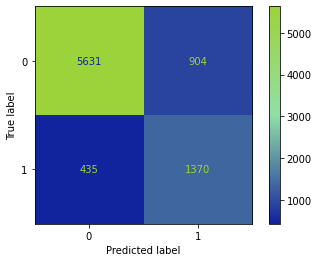

In [146]:
arvore = DecisionTreeClassifier(random_state=SEED)
arvore.fit(X_balanceado_under, y_balanceado_under)
previsao_arvore = arvore.predict(x_teste)

print(classification_report(y_teste, previsao_arvore))

ConfusionMatrixDisplay.from_estimator(arvore, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('under-DecisionTree.png', format='png')
plt.show()

#### GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6535
           1       0.78      0.71      0.74      1805

    accuracy                           0.89      8340
   macro avg       0.85      0.83      0.84      8340
weighted avg       0.89      0.89      0.89      8340



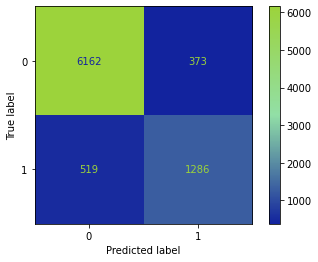

In [147]:
gboost = GradientBoostingClassifier(random_state=SEED)
gboost.fit(X_balanceado_under, y_balanceado_under)
previsao_gboost = gboost.predict(x_teste)

print(classification_report(y_teste, previsao_gboost))

ConfusionMatrixDisplay.from_estimator(gboost, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('under-GradientBoosting.png', format='png')
plt.show()

#### LogisticRegression

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      6535
           1       0.62      0.51      0.56      1805

    accuracy                           0.83      8340
   macro avg       0.74      0.71      0.72      8340
weighted avg       0.82      0.83      0.82      8340



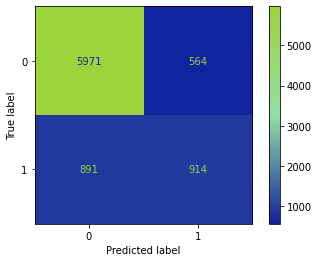

In [148]:
reg_logistica = LogisticRegression(random_state=SEED, max_iter =1000)
reg_logistica.fit(X_balanceado_under, y_balanceado_under)
previsao_reglog = reg_logistica.predict(x_teste)

print(classification_report(y_teste, previsao_reglog))

ConfusionMatrixDisplay.from_estimator(reg_logistica, x_teste, y_teste, cmap = mapa_calor)
plt.grid(False)
plt.savefig('under-LogisticRegression.png', format='png')
plt.show()

Os resultados dos modelos utilizando a técnica de undersampling serão salvos para posterior comparação com a técnica de oversampling.

In [149]:
metricas_under = pd.DataFrame({'Acurácia treino':[arvore.score(x_treino, y_treino), 
                                 gboost.score(x_treino, y_treino), 
                                 reg_logistica.score(x_treino, y_treino)], 
            'Acurácia teste': [arvore.score(x_teste, y_teste), 
                                 gboost.score(x_teste, y_teste), 
                                 reg_logistica.score(x_teste, y_teste)], 
            'Recall':[recall_score(y_teste, previsao_arvore),
                      recall_score(y_teste, previsao_gboost),
                      recall_score(y_teste, previsao_reglog)]},
             index = ['Árvore de Decisão Undersampling', 'Gradient Boosting Undersampling', 'Regressão Logísitica Undersampling'])

In [150]:
metricas_under

,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Undersampling,0.951873,0.839448,0.759003
Gradient Boosting Undersampling,0.903586,0.893046,0.712465
Regressão Logísitica Undersampling,0.831475,0.825540,0.506371


## Comparando samplings

In [151]:
display(metricas_over,metricas_under)

,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Oversampling,1.000000,0.851079,0.755125
Gradient Boosting Oversampling,0.871208,0.860671,0.752909
Regressão Logísitica Oversampling,0.771835,0.752638,0.727424


,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Undersampling,0.951873,0.839448,0.759003
Gradient Boosting Undersampling,0.903586,0.893046,0.712465
Regressão Logísitica Undersampling,0.831475,0.825540,0.506371


Analisando as tabelas, foi possível tirar as seguintes conclusões:

* A regressão logística apresenta um baixo desempenho em relação aos demais modelos, tanto no oversampling quanto undersampling.
* A árvore de decisão apresenta overfitting tanto no oversampling quanto undersampling. Isso ocorre quando desempenho é alto em dados de treino mas não generaliza bem para os dados de teste.
* O gradient boosting foi o modelo mais consistente, não apresentando overfiting.

Vamos analisar as matrizes de confusão do Gradient Boosting usando as técnicas de oversampling e undersampling:



- Oversampling - gradientBoosting

<img src="over-GradientBoosting.png">

- Undersampling - gradientBoosting

<img src="under-GradientBoosting.png">

É possível identificar que o modelo de gradient boosting usando técnica undersampling possui um resultado geral melhor, com menos erros do que o modelo que usa a técnica de oversampling.

Apesar de o recall do modelo que usa o oversampling ser melhor, ocasiona em um erro muito maior para os clientes não inadimplentes em relação ao modelo que usa o undersampling, o que pode gerar uma insatisfação muito grande nos clientes e perder grande parte do potencial de lucro da empresa.

O modelo escolhido foi o Gradient Boosting usando a técnica de undersampling.

## Otimização de hiperparâmetros

Vamos passar agora para a otimização de hiperparâmetros do modelo selecionado com o GridSearch.

In [152]:
from sklearn.model_selection import GridSearchCV
import numpy as np

Parâmetros a serem testados:

In [153]:
parameters = {
    "loss":["deviance"],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "absolute_error"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9],
    "n_estimators":[10,100]
    }


In [154]:
grid_search = GridSearchCV(GradientBoostingClassifier(random_state = SEED), parameters,scoring='recall',cv=3,verbose = 1)

grid_search.fit(X_balanceado_under, alvo_balanceado_under)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\ricar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new param

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=144),
             param_grid={'criterion': ['friedman_mse', 'absolute_error'],
                         'loss': ['deviance'], 'max_depth': [3, 5, 8],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [10, 100],
                         'subsample': [0.5, 0.618, 0.8, 0.85, 0.9]},
             scoring='recall', verbose=1)

In [155]:
grid_search.cv_results_

{'mean_fit_time': array([7.03335603e-02, 6.33328756e-02, 6.66666031e-02, 6.00011349e-02,
        7.09973971e-02, 6.06666803e-01, 6.15000566e-01, 5.79334021e-01,
        5.62998454e-01, 5.85668802e-01, 5.56681951e-02, 6.00001017e-02,
        6.06664817e-02, 5.93370597e-02, 6.19992415e-02, 5.27665059e-01,
        5.59332053e-01, 5.52335183e-01, 5.39000273e-01, 5.60001055e-01,
        7.99977779e-02, 9.06645457e-02, 9.79951223e-02, 9.23344294e-02,
        9.53342120e-02, 8.26663176e-01, 1.18233267e+00, 1.11366606e+00,
        9.12337144e-01, 8.76998663e-01, 8.10016791e-02, 8.46672058e-02,
        9.39992269e-02, 1.44668261e-01, 1.00000938e-01, 7.88001617e-01,
        8.20663214e-01, 9.04335976e-01, 9.95674213e-01, 9.45663055e-01,
        2.04665581e-01, 2.17663685e-01, 2.32667446e-01, 2.35002120e-01,
        2.54000664e-01, 1.99666572e+00, 2.37933238e+00, 2.56666613e+00,
        2.31333256e+00, 2.57133420e+00, 2.31000821e-01, 2.56669680e-01,
        2.68998146e-01, 2.24666993e-01, 2.36666

In [156]:
previsao_grid_search = grid_search.best_estimator_
previsao_grid = previsao_grid_search.predict(x_teste)

Retornando o melhor estimador encontrado pelo Grid Search:

In [157]:
grid_search.best_estimator_

GradientBoostingClassifier(loss='deviance', max_depth=8, max_features='log2',
                           random_state=144, subsample=0.618)

In [158]:
print(classification_report(alvo_teste, previsao_grid))

NameError: name 'alvo_teste' is not defined

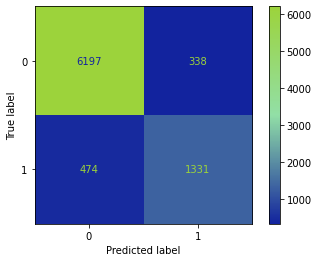

In [ ]:
ConfusionMatrixDisplay.from_estimator(previsao_grid_search, x_teste, alvo_teste, cmap = mapa_calor)
plt.grid(False)
plt.show()

Através do resultado, podemos verificar que o desempenho aumentou, principalmente entre os clientes não inadimplentes e esse será o modelo que será colocado em produção.

## Resumo

> Primeiramente, coletamos os dados da semana 1 e iniciamos uma análise focada no tratamento de dados para serem inseridos em um modelo de ML. Desse modo, removemos valores nulos e outliers presentes nos dados, bem como aplicamos o balanceamento, normalização e enconding para tratar o conjunto de dados.

> Assim, construimos três modelos de aprendizado de máquina pensando na explicabilidade do resultado final, comparamos o desempenho deles para o projeto e escolhemos o que teve melhor performance. Com isso, buscamos melhorar ainda mais o resultado final do modelo com uma otimização de hiperparâmetros e, assim que obtivemos um bom produto final, salvamos o modelo fazendo sua exportação.

## Exportando modelos

Iremos exportar os modelos para que possam ser utilizados futuramente fora do ambiente do Google Colaboratory

In [ ]:
import pickle

Modelo one hot encoder:

In [ ]:
with open('one_hot_encoder.pkl', 'wb') as file:
    pickle.dump(one_hot_enc, file)

Modelo de normalização dos dados:

In [ ]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

Modelo do gradient boosting do grid search:

In [ ]:
with open('modelo_treinado.pkl', 'wb') as file:
    pickle.dump(previsao_grid_search, file)